<a href="https://colab.research.google.com/github/niccolot/Quantum_computing/blob/main/quantum_machine_learning/prova_reuploading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.7.0
!pip install tensorflow-quantum==0.7.2


In [3]:
import tensorflow as tf
#import tensorflow_quantum as tfq
#import cirq
import sympy
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
#from cirq.contrib.svg import SVGCircuit

In [2]:
def one_qubit_rotation(qubit, symbols):
    """
    returns list of gates that rotate the single qubit
    by angle \vect{theta} = (symbols[0], symbols[1], symbols[2]) 
    """

    return [cirq.rx(symbols[0])(qubit),
            cirq.ry(symbols[1])(qubit),
            cirq.rz(symbols[2])(qubit)]


def entangling_layer(qubits):
    """
    Returns a layer of CZ entangling gates on the qubits list 
    entangling sequentially the quibits in the list and 
    finally the first with the last like 

    [cz(q0,q1), cz(q1,q2), ... cz(qn-1,qn), cz(qn,q0)]
    """

    cz_ops = [cirq.CZ(q0, q1) for q0, q1 in zip(qubits, qubits[1:])]
    cz_ops += ([cirq.CZ(qubits[0], qubits[-1])] if len(qubits) != 2 else [])

    return cz_ops


def generate_circuit(qubits, n_layers, input_features, use_entanglement=True, use_terminal_entanglement=True):
    """
    Prepares a data re-uploading circuit on `qubits` with `n_layers` layers

    args: 
        qubits: (int) number of qubits desired

        n_layers: (int) number of layers desired

        input_features: (int) number of features of the data 
                        e.g. 3x3 images has 9 features

        use_entanglement: (bool) if to insert an entanglement layer between the 
                          variational gates
        
        use_terminal_entanglement: (bool) if to use entanglement layer at the end of
                                   the circuit

    
    returns: the data reuploading circuit and a list of the variational parameters 
    """

    n_qubits = len(qubits)

    # Zero-pad the inputs and params if it is not a multiple of 3
    padding = (3 - (input_features % 3)) % 3

    # Sympy symbols for weights and bias parameters
    params = sympy.symbols(f'theta(0:{(input_features + padding) * n_layers * n_qubits})')
    params = np.asarray(params).reshape((n_layers, n_qubits, (input_features + padding)))

    circuit = cirq.Circuit()
    for l in range(n_layers):
        for gate in range(int(np.ceil(input_features/3))):

            # Variational layer
            circuit += cirq.Circuit(
                one_qubit_rotation(q, params[l, i, gate * 3:(gate + 1) * 3]) for i, q in enumerate(qubits))

        # Entangling layer
        if n_qubits >= 2 and (l != (n_layers - 1) or n_layers == 1) and use_entanglement:
            circuit += entangling_layer(qubits)
        if n_qubits >= 2 and use_terminal_entanglement and (l == (n_layers - 1) and n_layers != 1):
            circuit += entangling_layer(qubits)

    return circuit, list(params.flat)

In [3]:
class ReUploadingPQC(tf.keras.layers.Layer):
    def __init__(self, n_qubits, n_layers, input_size, use_entanglement=True, use_terminal_entanglement=True,
                    observables=None, name="re-uploading_PQC"):
        super(ReUploadingPQC, self).__init__(name=name)
        self.n_layers = n_layers
        self.n_qubits = n_qubits
        self.input_size = input_size
        self.use_entanglement = use_entanglement
        self.use_terminal_entanglement = use_terminal_entanglement
        self.main_name = name

        self.qubits = cirq.GridQubit.rect(1, n_qubits)
        if observables is None:
            self.observables = [cirq.Z(self.qubits[-1])]  # Measure only the last qubit
        else:
            self.observables = observables  # Custom observables

        # Generate the data re-uploading circuit
        self.circuit, theta_symbols = generate_circuit(self.qubits, self.n_layers, self.input_size,
                                                       use_entanglement=self.use_entanglement,
                                                       use_terminal_entanglement=self.use_terminal_entanglement)

        # Define explicit symbol order.
        symbols = [str(symb) for symb in theta_symbols]
        self.indices = tf.constant([sorted(symbols).index(a) for a in symbols])

        # Thetas (bias) initialization
        thetas_init = tf.random_uniform_initializer(minval=-0.1, maxval=0.1)
        self.thetas = tf.Variable(
            initial_value=thetas_init(shape=(1, len(theta_symbols)), dtype="float32"),
            trainable=True, name=self.main_name + "-thetas"
        )

        # Weights initialization
        w_init = tf.random_uniform_initializer(minval=-0.1, maxval=0.1)
        self.w = tf.Variable(
            initial_value=w_init(shape=(1, len(theta_symbols)), dtype="float32"),
            trainable=True, name=self.main_name + "-weights"
        )

        # Dummy inputs initialization
        # Using the empty circuits as hacks for ControlledPQC
        self.empty_circuit = tfq.convert_to_tensor([cirq.Circuit()])

        self.computation_layer = tfq.layers.ControlledPQC(self.circuit, self.observables)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'n_qubits': self.n_qubits,
            'n_layers': self.n_layers,
            'input_size': self.input_size,
            'use_entanglement': self.use_entanglement,
            'use_terminal_entanglement': self.use_terminal_entanglement,
            'name': self.main_name,
        })
        return config

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # Flatten inputs (from 2D images to 1D array)
        inputs_flattened = tf.keras.layers.Flatten()(inputs)

        # Pad the inputs if it is not a multiple of 3
        padding = 3 - inputs_flattened.shape[1] % 3
        if padding % 3 != 0:
            inputs_flattened = tf.pad(inputs_flattened, tf.constant([[0, 0, ], [0, padding]]))

        # Repeat the inputs for every layer and qubit
        inputs_flattened = tf.tile(inputs_flattened, tf.constant([1, self.n_layers * self.n_qubits]))

        # Weight the inputs (x' = wx)
        inputs_weighted = tf.math.multiply(self.w, inputs_flattened, name=self.main_name + '-weighted_inputs')
        # Bias the inputs (x' = x + b)
        inputs_weighted_biased = tf.math.add(inputs_weighted, self.thetas,
                                             name=self.main_name + '-weighted_inputs_plus_bias')

        # Duplicate dummy inputs
        # One for every batch in order to do batched training
        empty_circuit_batch = tf.repeat(self.empty_circuit, repeats=batch_size,
                                        name=self.main_name + '-tiled_up_empty_circuits')

        joined_params = tf.gather(inputs_weighted_biased, self.indices, axis=-1, name=self.main_name + '-joined_params')

        return self.computation_layer([empty_circuit_batch, joined_params])

In [10]:
class QConv2D_DRC:
    def __init__(self, filters, kernel_size, strides, drc_hyperparameters, layer_id, padding=None):
        self.filters = filters
        self.layer_id = layer_id
        self.padding = padding

        self.n_qubits = drc_hyperparameters["n_qubits"]
        self.n_layers = drc_hyperparameters["n_layers"]

        if any(np.array(self.n_qubits) != 1):
            self.use_ent = drc_hyperparameters["use_ent"]
            self.use_terminal_ent = drc_hyperparameters["use_terminal_ent"]
        else:
            # If every conv layer has 1 qubit define a dummy variable 
            # for compatibility like a list of bools (all of them False) 
            self.use_ent = list(np.ones(len(self.n_qubits), dtype=bool))
            self.use_terminal_ent = list(np.ones(len(self.n_qubits), dtype=bool))

        if type(kernel_size) == int:
            self.h_kernel_size = kernel_size
            self.w_kernel_size = kernel_size
        else:
            self.h_kernel_size = kernel_size[0]
            self.w_kernel_size = kernel_size[1]

        if type(strides) == int:
            self.h_stride = strides
            self.w_stride = strides
        else:
            self.h_stride = strides[0]
            self.w_stride = strides[1]

    def qconv_drc_operation(self, h_iter, w_iter, n_qubits, n_layers, use_entanglement, use_terminal_entanglement,
                            inputs, filter_id, channel_id, name="QConv_Operation"):
        """
        The 'quantum convolution' function itself
        
        args:
            h_iter, w_iter: (int) how many slides to do height and width wise

            inputs: (tensor) batch of one channel of the input images so shape = (batch_size, height, width)

            filter_id, channel_id: (str) the name of the keras layers, not important
                                in practice but keras needs different names for 
                                different layers

            the other args are the same as in the ReUploadingPQC

        returns: (list) the batch of convolutions calculated on the input image
        """

        pqc = ReUploadingPQC(n_qubits, n_layers, self.h_kernel_size * self.w_kernel_size,
                             use_entanglement=use_entanglement, use_terminal_entanglement=use_terminal_entanglement,
                             name=name + '_' + str(self.layer_id) + '_' + str(filter_id) + '_' + str(channel_id))

        conv = []
        for i in range(h_iter):
            for j in range(w_iter):
                temp = pqc(inputs[:, self.h_stride * i:self.h_stride * i + self.h_kernel_size,
                           self.w_stride * j:self.w_stride * j + self.w_kernel_size])
                conv += [temp]
        output = tf.keras.layers.Concatenate(axis=1)(conv)
        output = tf.keras.layers.Reshape((h_iter, w_iter, 1))(output)

        return output

    def call(self, inputs):
        # Calculate the number of convolution iterations
        h_iter = 1 + (inputs.shape[1] - self.h_kernel_size) / self.h_stride
        w_iter = 1 + (inputs.shape[2] - self.w_kernel_size) / self.w_stride

        if self.padding is None:
            h_iter = int(h_iter)
            w_iter = int(w_iter)

        if self.padding == "valid":
            h_iter = math.ceil(h_iter)
            w_iter = math.ceil(w_iter)
            h_pad_size = (h_iter - 1) * self.h_stride + self.h_kernel_size - inputs.shape[1]
            w_pad_size = (w_iter - 1) * self.w_stride + self.w_kernel_size - inputs.shape[2]
            
            padding_constant = tf.constant([[0, 0], [0, h_pad_size], [0, w_pad_size], [0, 0]])
            inputs = tf.pad(inputs, padding_constant)

        # Do the convolutional operation for all filters
        filter_output = []
        for filter in range(self.filters):
            # input channel iteration
            channel_outputs = []
            for channel in range(inputs.shape[-1]):
                channel_outputs += [
                    self.qconv_drc_operation(h_iter, w_iter,
                                             self.n_qubits[channel],
                                             self.n_layers[channel],
                                             self.use_ent[channel],
                                             self.use_terminal_ent[channel],
                                             inputs[:, :, :, channel],
                                             filter_id=filter + 1, channel_id=channel + 1)
                ]

            # Add the convolution outputs between input channels
            if inputs.shape[-1] > 1:
                filter_output += [tf.keras.layers.Add()(channel_outputs)]
            else:
                filter_output += channel_outputs

        # Concatenate the filter outputs
        if self.filters > 1:
            layer_output = tf.keras.layers.Concatenate(axis=-1)(filter_output)
        else:
            layer_output = filter_output[0]

        return layer_output

In [20]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train_flatten = x_train/255.0
x_test_flatten = x_test/255.0

x_train_0 = x_train_flatten[y_train == 0]
x_train_1 = x_train_flatten[y_train == 1]
x_train_2 = x_train_flatten[y_train == 2]
x_train_3 = x_train_flatten[y_train == 3]
x_train_4 = x_train_flatten[y_train == 4]
x_train_5 = x_train_flatten[y_train == 5]
x_train_6 = x_train_flatten[y_train == 6]
x_train_7 = x_train_flatten[y_train == 7]
x_train_8 = x_train_flatten[y_train == 8]
x_train_9 = x_train_flatten[y_train == 9]

x_train_list = [x_train_0, x_train_1, x_train_2, x_train_3, x_train_4, x_train_5, x_train_6, x_train_7, x_train_8, x_train_9]

x_test_0 = x_test_flatten[y_test == 0]
x_test_1 = x_test_flatten[y_test == 1]
x_test_2 = x_test_flatten[y_test == 2]
x_test_3 = x_test_flatten[y_test == 3]
x_test_4 = x_test_flatten[y_test == 4]
x_test_5 = x_test_flatten[y_test == 5]
x_test_6 = x_test_flatten[y_test == 6]
x_test_7 = x_test_flatten[y_test == 7]
x_test_8 = x_test_flatten[y_test == 8]
x_test_9 = x_test_flatten[y_test == 9]

x_test_list = [x_test_0, x_test_1, x_test_2, x_test_3, x_test_4, x_test_5, x_test_6, x_test_7, x_test_8, x_test_9]


In [21]:
class_set = [0, 1]

training_sample_per_class = 750  # number of training samples per class
X_train = np.concatenate((x_train_list[class_set[0]][:training_sample_per_class, :], x_train_list[class_set[1]][:training_sample_per_class, :]), axis=0)
Y_train = np.zeros((X_train.shape[0],), dtype=int)
Y_train[training_sample_per_class:] += 1

print("Train Set Shape:", X_train.shape, Y_train.shape)

testing_sample_per_class = 250  # number of testing samples per class
X_test = np.concatenate((x_test_list[class_set[0]][:testing_sample_per_class, :], x_test_list[class_set[1]][:testing_sample_per_class, :]), axis=0)
Y_test = np.zeros((X_test.shape[0],), dtype=int)
Y_test[testing_sample_per_class:] += 1

print("Test Set Shape:", X_test.shape, Y_test.shape)

Train Set Shape: (1500, 28, 28) (1500,)
Test Set Shape: (500, 28, 28) (500,)


In [18]:
# Full size MNIST images as input with shape (28, 28, 1)
input_tensor = tf.keras.Input(shape=(28, 28, 1), dtype=tf.dtypes.float32, name='input')

drc_settings = {
    "n_qubits": [1],
    "n_layers": [1],
    "use_ent": [True],
    "use_terminal_ent": [True]
}

# Two quantum convolution layers
qconv_1 = QConv2D_DRC(1, (3,3), (2,2), drc_settings, 1, padding="valid").call(input_tensor)
qconv_2 = QConv2D_DRC(1, (3,3), (2,2), drc_settings, 2, padding="valid").call(qconv_1)

# A max pooling layer
pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding="valid")(qconv_2)

# Flatten the tensor
flat = tf.keras.layers.Flatten()(pool)

# A classical fully-connected layer
classical_dense = tf.keras.layers.Dense(2, activation='softmax')(flat)

model = tf.keras.Model(inputs=[input_tensor], outputs=classical_dense)

In [12]:
def lr_schedule(epoch, lr_init=1e-3):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
        lr_init (float32): initial learning rate, default: 1e-3
    """
    lr = lr_init
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

In [19]:
# Training parameters
BATCH_SIZE = 32
EPOCHS = 10

# Print parameters for sanity check
print("Batch size, epochs:", BATCH_SIZE, EPOCHS)

# Optimizer with learning rate scheduler
opt_adam = tf.keras.optimizers.Adam(lr=lr_schedule(0, lr_init=0.01))

# Compile the model with cross-entropy loss
model.compile(loss='categorical_crossentropy',
              optimizer=opt_adam,
              metrics='accuracy')

Batch size, epochs: 32 10
Learning rate:  0.01


Epoch 1/10
47/47 [==============================] - 228s 3s/step - loss: 0.7030 - accuracy: 0.5127 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 2/10
47/47 [==============================] - 109s 2s/step - loss: 0.6765 - accuracy: 0.6260 - val_loss: 0.6313 - val_accuracy: 0.7420
Epoch 3/10
47/47 [==============================] - 110s 2s/step - loss: 0.4425 - accuracy: 0.8667 - val_loss: 0.3046 - val_accuracy: 0.9060
Epoch 4/10
47/47 [==============================] - 108s 2s/step - loss: 0.2320 - accuracy: 0.9347 - val_loss: 0.1953 - val_accuracy: 0.9420
Epoch 5/10
47/47 [==============================] - 112s 2s/step - loss: 0.1645 - accuracy: 0.9513 - val_loss: 0.1470 - val_accuracy: 0.9600
Epoch 6/10
47/47 [==============================] - 108s 2s/step - loss: 0.1454 - accuracy: 0.9573 - val_loss: 0.1448 - val_accuracy: 0.9540
Epoch 7/10
47/47 [==============================] - 111s 2s/step - loss: 0.1283 - accuracy: 0.9560 - val_loss: 0.1255 - val_accuracy: 0.9660
Epoch 8/10
47

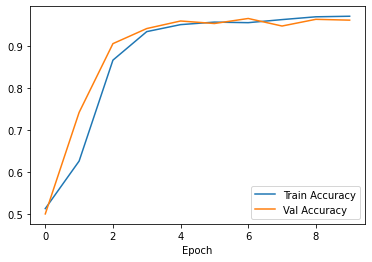

In [20]:
last_epoch = 0

# Train the model
H = model.fit(X_train, tf.keras.utils.to_categorical(Y_train), initial_epoch=last_epoch,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=(X_test, tf.keras.utils.to_categorical(Y_test)),
              shuffle=True)

# Print and plot the best metrics obtained during the training
print("Best Train Accuracy:", max(H.history['accuracy']))
print("Best Val Accuracy:", max(H.history['val_accuracy']))


plt.plot(H.history['accuracy'], label='Train Accuracy')
plt.plot(H.history['val_accuracy'], label='Val Accuracy')


plt.xlabel('Epoch')

plt.legend()
plt.show()

In [15]:
from tensorflow import keras
from keras import layers

def conv_block(
    input,
    num_filters,
    kernel_size=3,
    pool_size=2,
    padding='same',
    dropout=False,
    drop_rate=0.5,
    spatial_drop_rate = 0.3,
    activation='relu',):

    x = layers.Conv2D(
        filters=num_filters,
        kernel_size=kernel_size,
        padding=padding,
        activation=activation,
    )(input)
    
    return x


def fc_block(
    input,
    nodes,
    activation = 'relu',
):

    x = layers.Flatten()(input)

    x = layers.Dense(nodes,
    activation=activation)(x)

    return x


def build_model(img_size, num_classes):

    input = keras.Input(shape=(img_size,img_size,1))

    x = conv_block(input, num_filters=1)
    #x = conv_block(x, num_filters=32)
    x = layers.MaxPooling2D(4)(x)
    x = fc_block(x, nodes=2)

    output = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs=input, outputs=output)

In [23]:
learning_rate = 0.01
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

c_model = build_model(28, 2)

c_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy']
)


In [24]:
c_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 1)         10        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 1)          0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 49)                0         
                                                                 
 dense_8 (Dense)             (None, 2)                 100       
                                                                 
 dense_9 (Dense)             (None, 2)                 6         
                                                           

Epoch 1/10
47/47 [==============================] - 1s 24ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 0.9980
Epoch 2/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 5.1626e-04 - val_accuracy: 1.0000
Epoch 3/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0015 - accuracy: 0.9993 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 4/10
47/47 [==============================] - 1s 13ms/step - loss: 6.4094e-04 - accuracy: 1.0000 - val_loss: 5.4963e-04 - val_accuracy: 1.0000
Epoch 5/10
47/47 [==============================] - 1s 14ms/step - loss: 5.1399e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 6/10
47/47 [==============================] - 1s 15ms/step - loss: 8.7573e-04 - accuracy: 1.0000 - val_loss: 4.9863e-04 - val_accuracy: 1.0000
Epoch 7/10
47/47 [==============================] - 1s 14ms/step - loss: 0.0036 - accuracy: 0.9987 - val_loss: 9.2428e-04 - val_ac

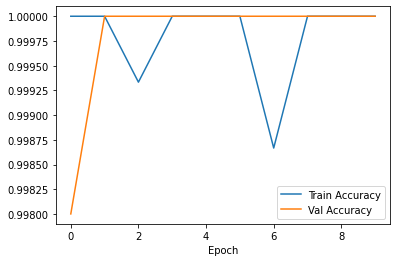

In [26]:
batch_size = 32
epochs = 10
H = c_model.fit(
    x = X_train,
    y = tf.keras.utils.to_categorical(Y_train),
    batch_size=batch_size,
    validation_data=(X_test, tf.keras.utils.to_categorical(Y_test)),
    epochs=epochs,
    shuffle=True,
)

print("Best Train Accuracy:", max(H.history['accuracy']))
print("Best Val Accuracy:", max(H.history['val_accuracy']))


plt.plot(H.history['accuracy'], label='Train Accuracy')
plt.plot(H.history['val_accuracy'], label='Val Accuracy')


plt.xlabel('Epoch')

plt.legend()
plt.show()